🎨 Starting analysis...


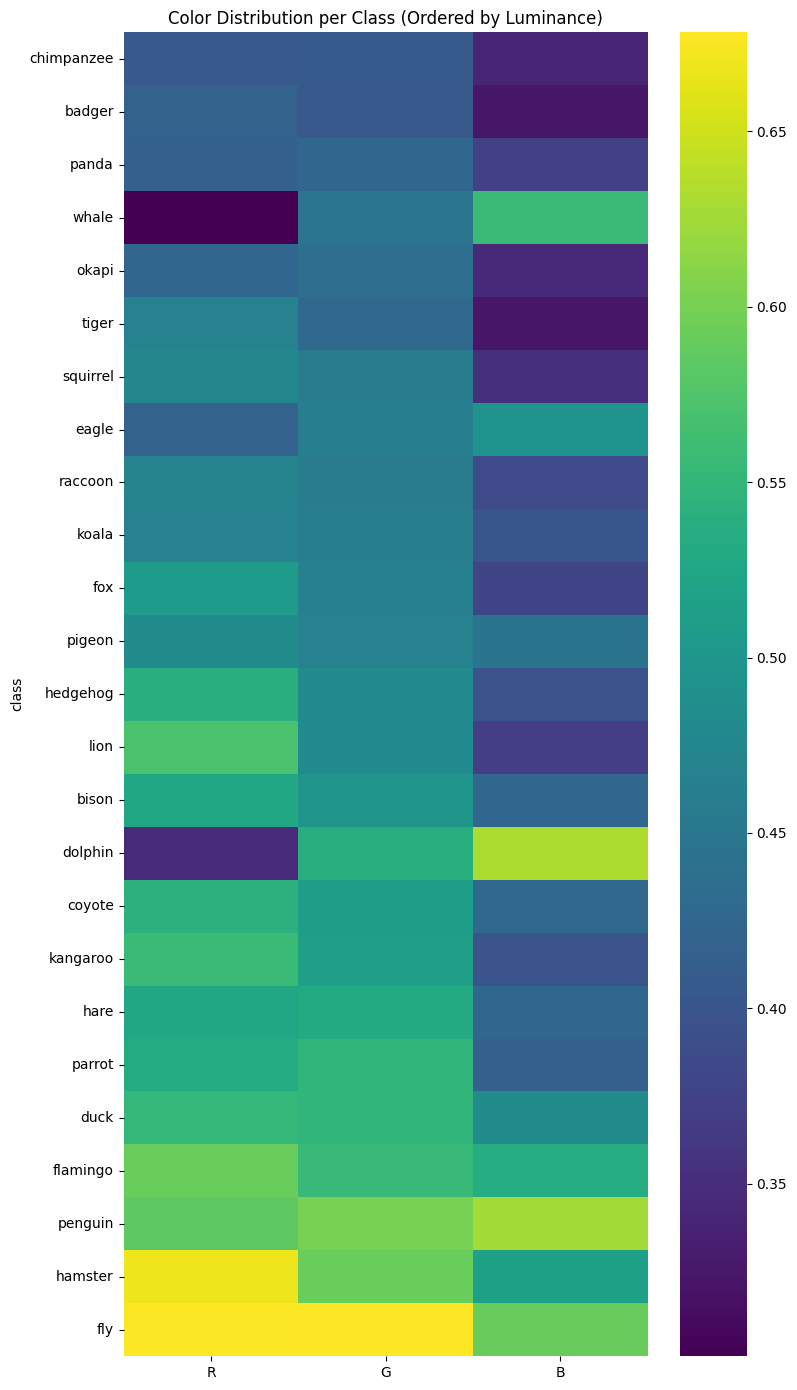

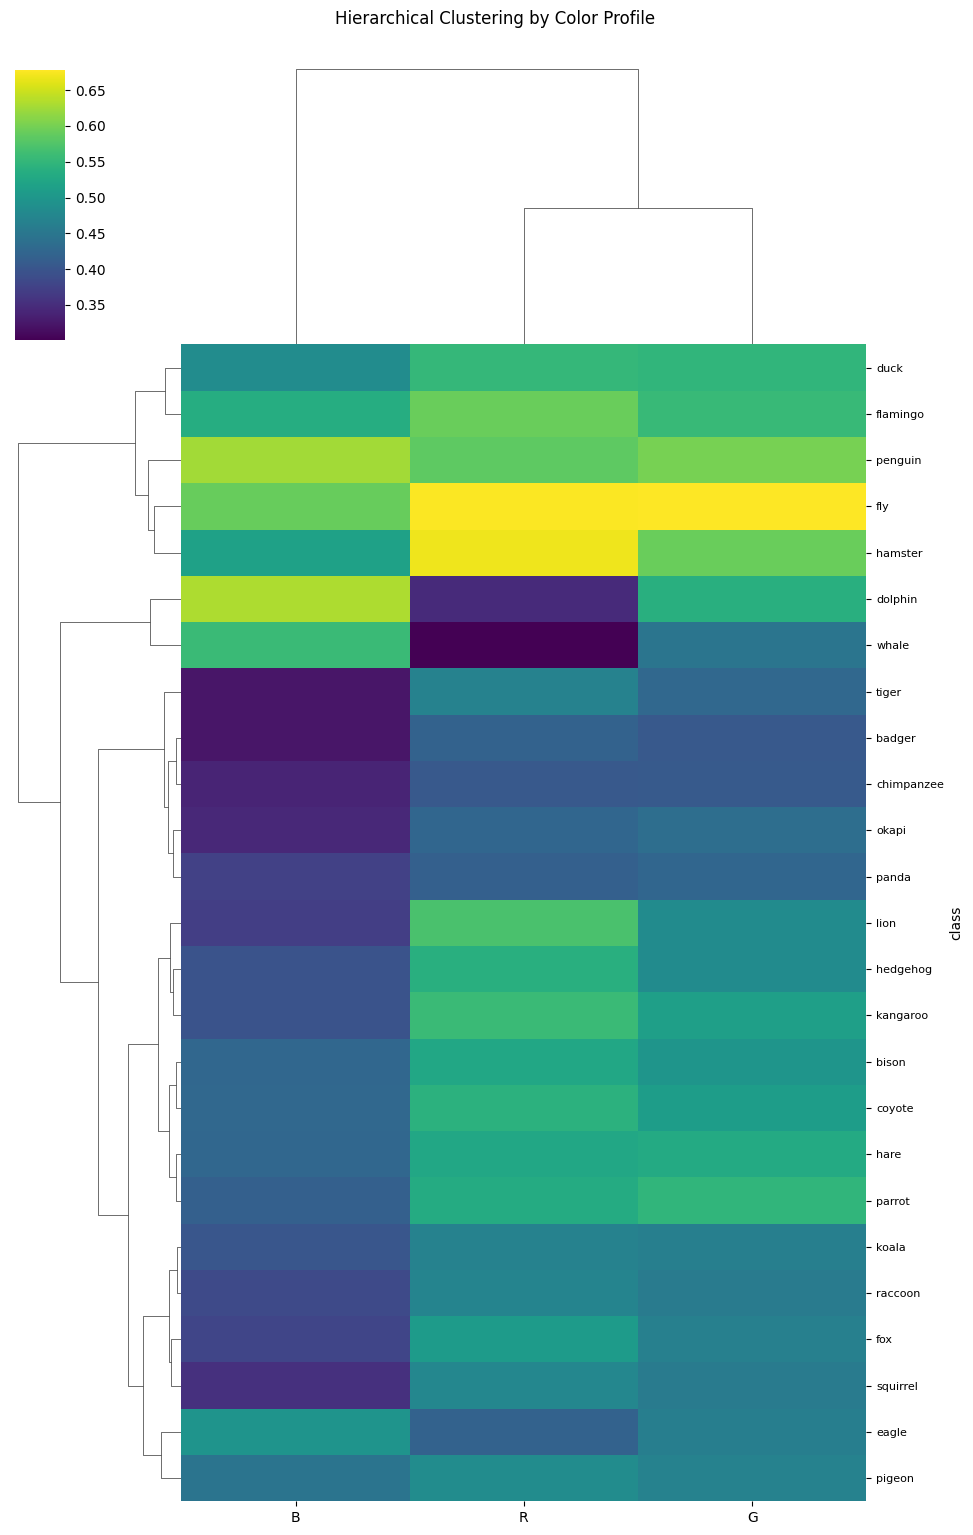

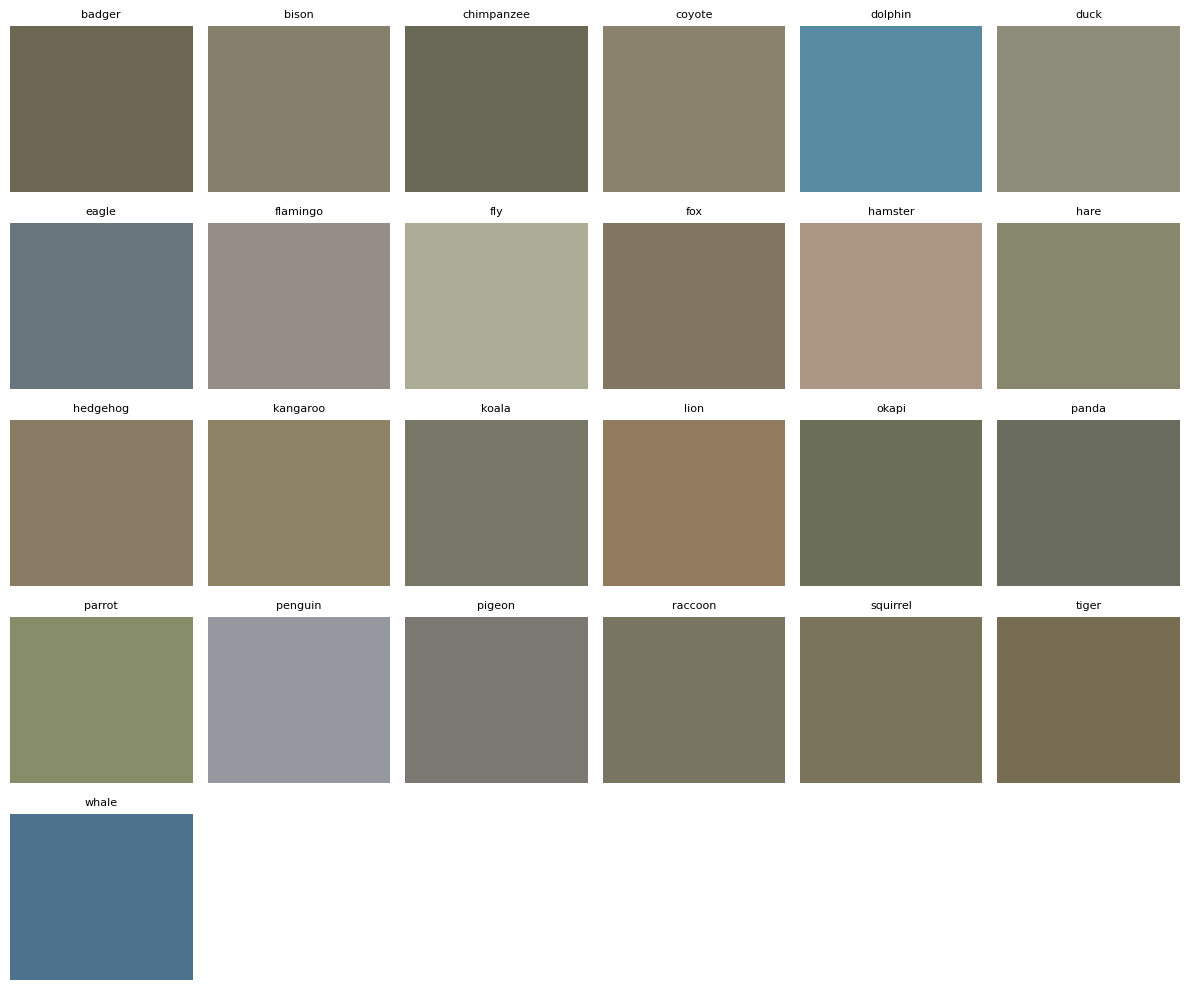

In [1]:
from pathlib import Path
import analysis_utils as utils  # Import your local script

# 1. Setup Paths
# Since the notebook and the script are in the same folder, this works automatically
current_dir = Path.cwd() 
data_dir = current_dir.parent / 'data'
plots_dir = current_dir.parent / 'reports' / 'figures'
plots_dir.mkdir(parents=True, exist_ok=True)

# 2. Run Analysis
print("🎨 Starting analysis...")
averages = utils.calculate_rgb_averages(data_dir)
df_metrics = utils.get_df_with_rgb_avg(averages)

# 3. Plot
if not df_metrics.empty:
    utils.plot_rgb_heatmap(df_metrics, plots_dir)
    utils.plot_clustermap(df_metrics, plots_dir)
    utils.plot_avg_colors(df_metrics, plots_dir)

✅ Successfully loaded results for 540 validation samples.
📊 Overall Validation Accuracy: 77.5926%


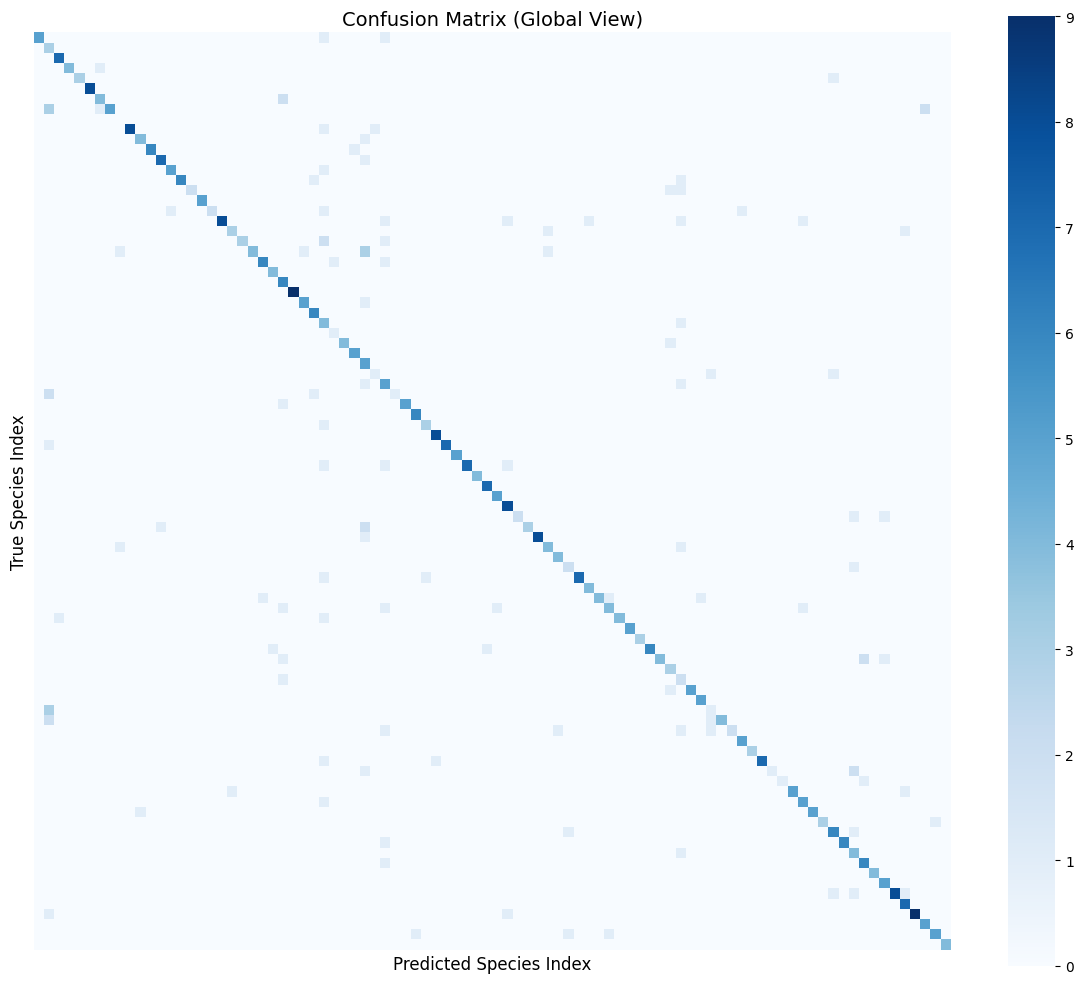

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# 1. Path Configuration
# Locate the project root relative to the notebook's location
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
results_dir = project_root / "reports" / "inference"
# 2. Load Inference Data
# These files are generated by running the 'animal-infer' command
try:
    val_probs = np.load(results_dir / "val_probs.npy")
    val_labels = np.load(results_dir / "val_labels.npy")
    # Paths are loaded here for use in subsequent diagnostic cells
    val_paths = np.load(results_dir / "val_paths.npy")
    
    print(f"✅ Successfully loaded results for {len(val_labels)} validation samples.")
except FileNotFoundError as e:
    print(f"❌ Could not find inference data in {results_dir}. Ensure 'animal-infer' has been run.")
    raise e

# 3. Accuracy Calculation
preds = val_probs.argmax(axis=1)
accuracy = accuracy_score(val_labels, preds)
print(f"📊 Overall Validation Accuracy: {accuracy:.4%}")

# 4. Confusion Matrix Visualization
# Provides a high-level view of misclassifications across all 90 species
cm = confusion_matrix(val_labels, preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    cmap="Blues", 
    square=True, 
    cbar=True, 
    xticklabels=False, 
    yticklabels=False
)

plt.title("Confusion Matrix (Global View)", fontsize=14)
plt.xlabel("Predicted Species Index", fontsize=12)
plt.ylabel("True Species Index", fontsize=12)
plt.tight_layout()
plt.show()

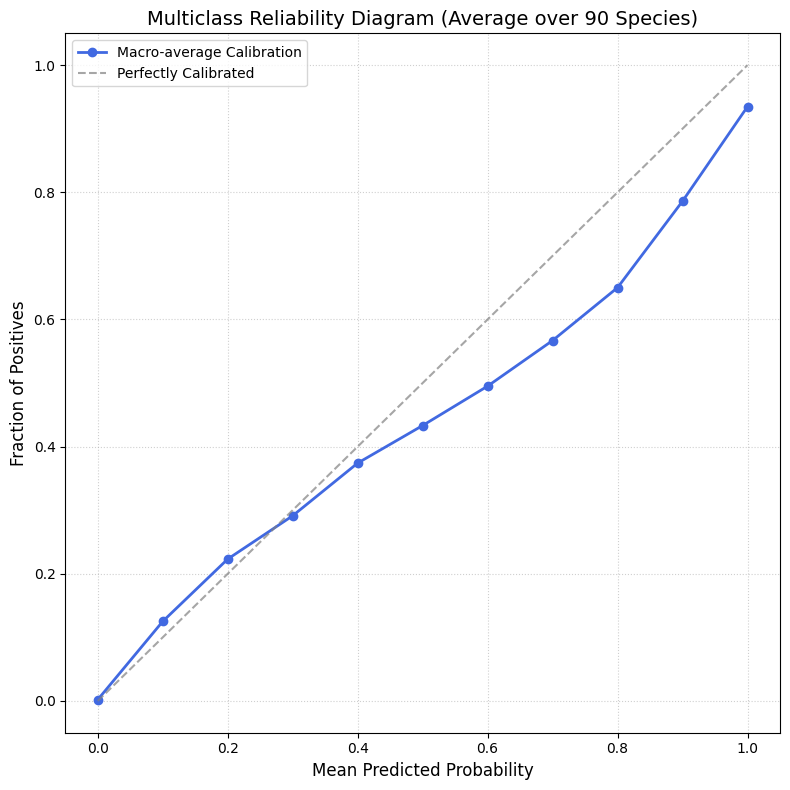

In [6]:
from sklearn.calibration import calibration_curve

# 1. Macro-Average Calibration Calculation
# One-hot encode labels to allow for per-class calibration analysis
num_classes = val_probs.shape[1]
y_true_onehot = np.eye(num_classes)[val_labels]

# Define a shared set of bins for interpolation and averaging
fixed_bins = np.linspace(0, 1, 11)
prob_true_all = []

for i in range(num_classes):
    y_true_i = y_true_onehot[:, i]
    y_prob_i = val_probs[:, i]

    # Skip classes with no positive samples in the validation set
    if np.sum(y_true_i) == 0:
        continue

    # Compute calibration curve for the specific class
    # prob_true: fraction of positives; prob_pred: mean predicted probability
    prob_true, prob_pred = calibration_curve(y_true_i, y_prob_i, n_bins=10, strategy='uniform')
    
    # Interpolate to shared bins to allow averaging across all species
    prob_true_interp = np.interp(fixed_bins, prob_pred, prob_true)
    prob_true_all.append(prob_true_interp)

# 2. Visualization
plt.figure(figsize=(8, 8))

if prob_true_all:
    prob_true_mean = np.mean(prob_true_all, axis=0)
    plt.plot(
        fixed_bins, 
        prob_true_mean, 
        marker="o", 
        linewidth=2, 
        color="royalblue", 
        label="Macro-average Calibration"
    )

# Perfect calibration reference line
plt.plot([0, 1], [0, 1], "--", color="gray", alpha=0.7, label="Perfectly Calibrated")

plt.xlabel("Mean Predicted Probability", fontsize=12)
plt.ylabel("Fraction of Positives", fontsize=12)
plt.title("Multiclass Reliability Diagram (Average over 90 Species)", fontsize=14)
plt.legend(loc="upper left")
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
from sklearn.metrics import classification_report

# 1. Load Class Names
# Locates the animal species names for legible reporting
names_path = project_root / "animal_classification" / "data" / "mini_animals" / "name_of_the_animals.txt"

if names_path.exists():
    with open(names_path, 'r', encoding='utf-8') as f:
        class_names = [line.strip() for line in f if line.strip()]
    print(f"✅ Loaded {len(class_names)} species names.")
else:
    print(f"⚠️ Metadata not found at {names_path}. Using numeric indices.")
    class_names = None

# 2. Generate Classification Report
# Compiles precision, recall, and F1-score for all classes
# zero_division=0 handles species not present in the current validation slice
report_dict = classification_report(
    val_labels, 
    preds, 
    labels=list(range(len(class_names))) if class_names else None,
    target_names=class_names if class_names else None,
    output_dict=True,
    zero_division=0
)

# 3. Summary Performance
print("\n======= Global Performance Metrics =======")
print(f"Accuracy:         {report_dict['accuracy']:.4f}")
print(f"Macro Avg F1:     {report_dict['macro avg']['f1-score']:.4f} (Unweighted class average)")
print(f"Weighted Avg F1:  {report_dict['weighted avg']['f1-score']:.4f} (Support-weighted average)")
print("-" * 42)

# 4. Species-Level Analysis
# Extract per-species metrics into a DataFrame for ranking
metrics_list = []
for key, value in report_dict.items():
    if (class_names and key in class_names) or key.isdigit():
        metrics_list.append({
            'Species': key,
            'Precision': value['precision'],
            'Recall': value['recall'],
            'F1-Score': value['f1-score'],
            'Support': value['support']
        })

df_metrics = pd.DataFrame(metrics_list).sort_values(by='F1-Score', ascending=False)

# 5. Identify Best and Worst Performers
# Only considers classes with actual samples (support > 0) for the bottom ranking
print("\n⭐ Top 5 Best Performing Species (by F1):")
print(df_metrics.head(5).to_string(index=False))

print("\n⚠️ Bottom 5 Worst Performing Species (by F1):")
df_valid_support = df_metrics[df_metrics['Support'] > 0]
print(df_valid_support.tail(5).to_string(index=False))

✅ Loaded 90 species names.

======= Global Performance Metrics =======
Accuracy:         0.7759
Macro Avg F1:     0.7663 (Unweighted class average)
Weighted Avg F1:  0.7893 (Support-weighted average)
------------------------------------------

⭐ Top 5 Best Performing Species (by F1):
   Species  Precision  Recall  F1-Score  Support
    beetle        1.0     1.0       1.0      8.0
      crow        1.0     1.0       1.0      5.0
  flamingo        1.0     1.0       1.0      9.0
    oyster        1.0     1.0       1.0      5.0
rhinoceros        1.0     1.0       1.0      3.0

⚠️ Bottom 5 Worst Performing Species (by F1):
Species  Precision   Recall  F1-Score  Support
hamster       0.50 0.333333  0.400000      3.0
   goat       0.25 0.800000  0.380952      5.0
 badger       0.20 1.000000  0.333333      3.0
    pig       0.20 0.666667  0.307692      3.0
 possum       0.25 0.250000  0.250000      4.0


### Worst Classified Animals

**Using paths: more robust**

🔍 Analyzing authentic samples for the 5 lowest-performing species: hamster, goat, badger, pig, possum


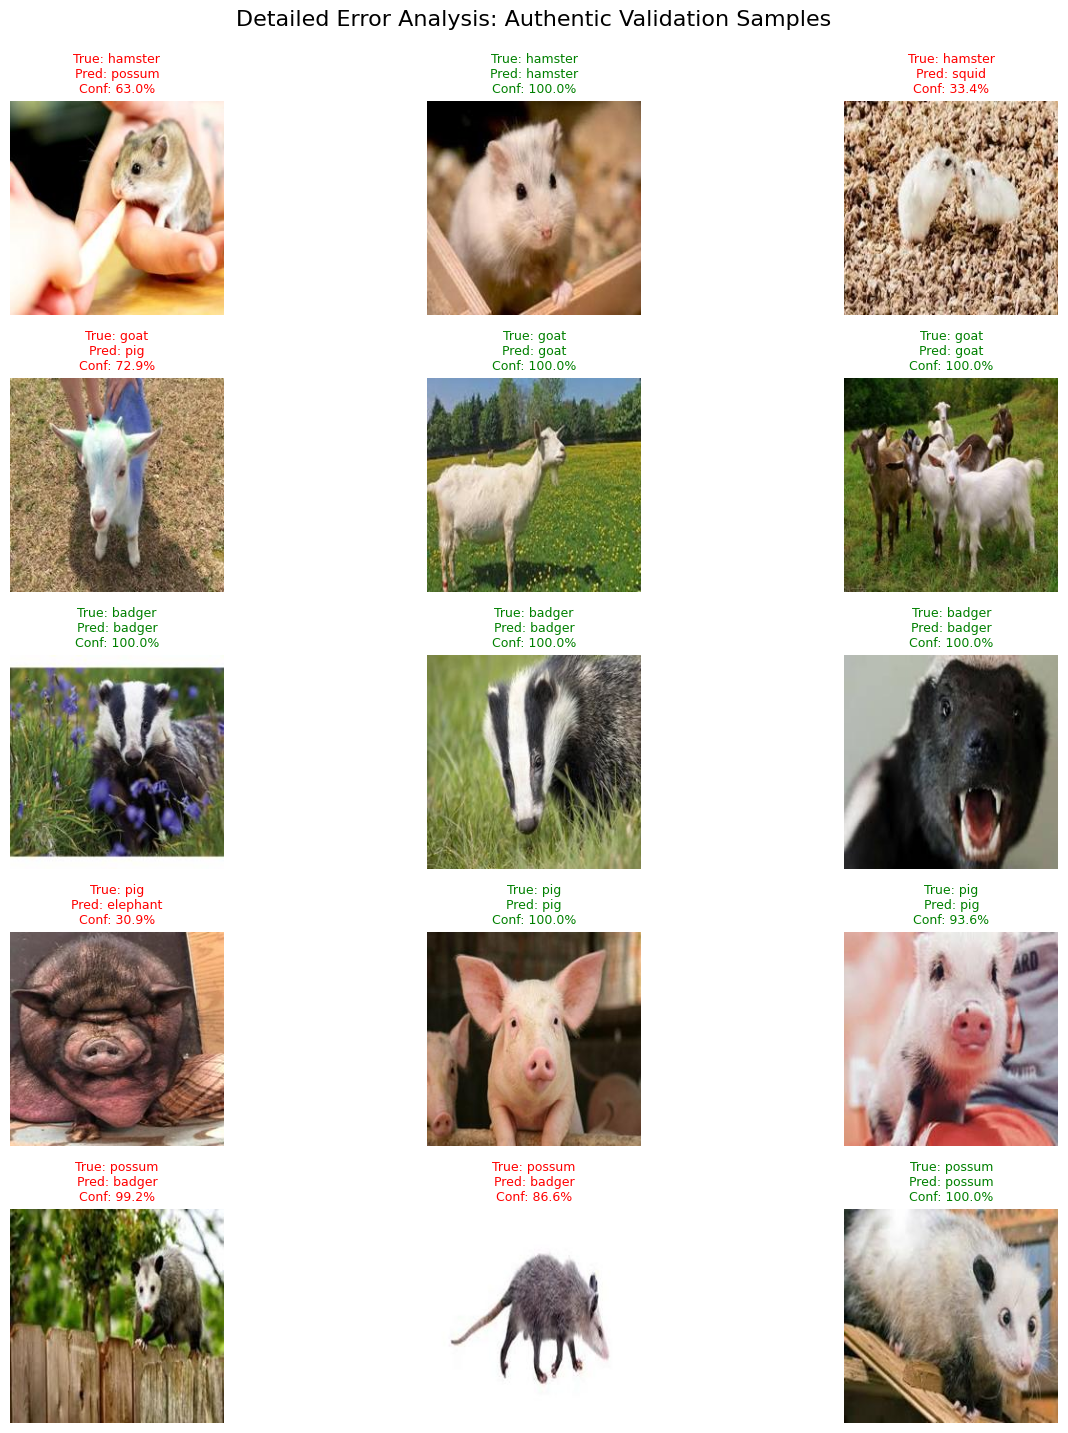

In [10]:
from PIL import Image

# 1. Identify Target Species
# We filter for 'Support > 0' to focus on species actually present in this validation set
df_valid = df_metrics[df_metrics['Support'] > 0]
worst_species = df_valid.tail(5)['Species'].tolist()

# Map species names to their original numeric indices
species_to_idx = {name: i for i, name in enumerate(class_names)}
target_indices = [species_to_idx[name] for name in worst_species]

print(f"🔍 Analyzing authentic samples for the 5 lowest-performing species: {', '.join(worst_species)}")

# 2. Visualization Configuration
samples_per_row = 3
n_rows = len(target_indices)
# Optimized figsize to reduce vertical whitespace
fig, axes = plt.subplots(n_rows, samples_per_row, figsize=(14, 2.8 * n_rows))

# Ensure axes is a 2D array for consistent indexing
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# 3. Process and Plot Samples
for i, species_idx in enumerate(target_indices):
    # Find all occurrences of this species in the validation data
    indices = np.where(val_labels == species_idx)[0]
    
    # Randomly sample up to 3 instances for visualization
    if len(indices) > 0:
        sampled_subset = np.random.choice(indices, min(len(indices), samples_per_row), replace=False)
    else:
        sampled_subset = []

    for j in range(samples_per_row):
        ax = axes[i, j]
        ax.axis('off')
        
        if j < len(sampled_subset):
            val_idx = sampled_subset[j]
            true_label = class_names[val_labels[val_idx]]
            pred_label = class_names[preds[val_idx]]
            confidence = val_probs[val_idx][preds[val_idx]]
            
            # --- Path Resolution Logic ---
            # Try original stored path, then attempt resolution relative to the project root
            raw_path = Path(val_paths[val_idx])
            img_path = raw_path if raw_path.exists() else project_root / raw_path
            
            # Final fallback to standard data structure if relative path fails
            if not img_path.exists():
                img_path = project_root / "data" / "mini_animals" / "animals" / true_label / raw_path.name
            
            # Title color indicates correctness
            title_color = "green" if true_label == pred_label else "red"
            ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1%}", 
                         color=title_color, fontsize=9)
            
            try:
                img = Image.open(img_path)
                ax.imshow(img)
            except Exception:
                ax.text(0.5, 0.5, f"Image Not Found:\n{raw_path.name}", 
                        ha='center', va='center', fontsize=8, color='gray')
        else:
            # Handle cases where species have fewer than 3 validation samples
            ax.text(0.5, 0.5, "No more samples", ha='center', va='center', color="lightgray", fontsize=8)

plt.tight_layout()
plt.suptitle("Detailed Error Analysis: Authentic Validation Samples", fontsize=16, y=1.02)
plt.show()

🐝 Analyzing 4 validation samples for: bee


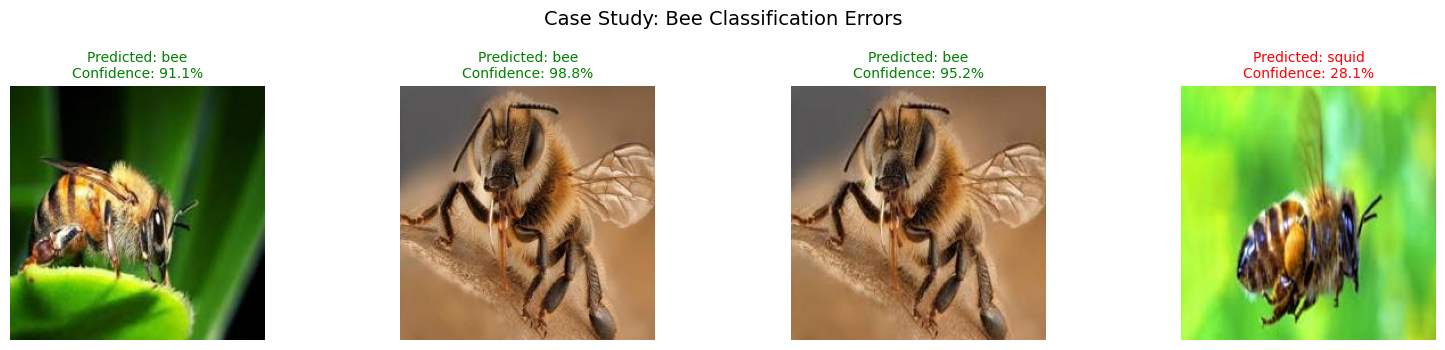

In [11]:
# --- Specialized Class Analysis ---
# Investigates specific confusion patterns for a single target species

target_species = "bee"

# Ensure the target species exists in our classification mapping
# (Assumes species_to_idx was defined in the previous Metrics cell)
if target_species in species_to_idx:
    class_idx = species_to_idx[target_species]
    val_indices = np.where(val_labels == class_idx)[0]
    
    if len(val_indices) > 0:
        # Display configuration: 4 samples in a single row
        num_samples = 4
        fig, axes = plt.subplots(1, num_samples, figsize=(16, 3.2))
        
        # Randomly select samples from the validation set for this class
        selected_indices = np.random.choice(val_indices, min(len(val_indices), num_samples), replace=False)
        
        print(f"🐝 Analyzing {len(selected_indices)} validation samples for: {target_species}")
        
        for k, val_idx in enumerate(selected_indices):
            ax = axes[k]
            ax.axis('off')
            
            # Retrieve model predictions and metadata
            predicted_name = class_names[preds[val_idx]]
            confidence = val_probs[val_idx][preds[val_idx]]
            
            # Title color provides immediate visual feedback on accuracy
            status_color = "green" if predicted_name == target_species else "red"
            ax.set_title(f"Predicted: {predicted_name}\nConfidence: {confidence:.1%}", 
                         color=status_color, fontsize=10)
            
            # Path resolution logic (Absolute -> Root-Relative -> Data-Root)
            raw_path = Path(val_paths[val_idx])
            img_path = raw_path if raw_path.exists() else project_root / raw_path
            
            if not img_path.exists():
                img_path = project_root / "data" / "mini_animals" / "animals" / target_species / raw_path.name

            try:
                img = Image.open(img_path)
                ax.imshow(img)
            except Exception:
                ax.text(0.5, 0.5, "Image Load Error", ha='center', va='center', fontsize=8, color='gray')
                
        plt.tight_layout()
        plt.suptitle(f"Case Study: {target_species.capitalize()} Classification Errors", fontsize=14, y=1.08)
        plt.show()
    else:
        print(f"ℹ️ No validation samples available for {target_species}.")
else:
    print(f"⚠️ Species '{target_species}' not found in the current classification index.")